In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
import pickle
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV


In [2]:
df=pd.read_csv("salaries.csv")

In [3]:
df.head()


,ResponseId,Q120,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I agree,None of these,18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I agree,I am a developer by profession,25-34 years old,"Employed, full-time",Remote,Hobby;Contribute to open-source projects;Boots...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;Friend or fam...,Formal documentation provided by the owner of ...,...,1-2 times a week,10+ times a week,Never,15-30 minutes a day,15-30 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,285000.0
2,3,I agree,I am a developer by profession,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby;Professional development or self-paced l...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Formal documentation provided by the owner of ...,...,6-10 times a week,6-10 times a week,3-5 times a week,30-60 minutes a day,30-60 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,250000.0
3,4,I agree,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Colleague;Friend or family member;Other online...,Formal documentation provided by the owner of ...,...,1-2 times a week,10+ times a week,1-2 times a week,15-30 minutes a day,30-60 minutes a day,Automated testing;Continuous integration (CI) ...,NaN,Appropriate in length,Easy,156000.0
4,5,I agree,I am a developer by profession,25-34 years old,"Employed, full-time;Independent contractor, fr...",Remote,Hobby;Contribute to open-source projects;Profe...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Online Courses or Certi...,Formal documentation provided by the owner of ...,...,1-2 times a week,1-2 times a week,3-5 times a week,60-120 minutes a day,30-60 minutes a day,Microservices;Automated testing;Observability ...,Other,Appropriate in length,Neither easy nor difficult,23456.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89184 entries, 0 to 89183
Data columns (total 84 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ResponseId                           89184 non-null  int64  
 1   Q120                                 89184 non-null  object 
 2   MainBranch                           89184 non-null  object 
 3   Age                                  89184 non-null  object 
 4   Employment                           87898 non-null  object 
 5   RemoteWork                           73810 non-null  object 
 6   CodingActivities                     73764 non-null  object 
 7   EdLevel                              87973 non-null  object 
 8   LearnCode                            87663 non-null  object 
 9   LearnCodeOnline                      70084 non-null  object 
 10  LearnCodeCoursesCert                 37076 non-null  object 
 11  YearsCode                   

In [5]:
#Columns I'm interested in:
df = df[[
    "Country",
    "EdLevel",
    "YearsCodePro",
    "Employment",
    "DevType",
    "OrgSize",
    "RemoteWork",
    "ConvertedCompYearly",
]]
df = df.rename({"ConvertedCompYearly": "Salary"}, axis=1)


In [6]:
df = df.dropna(subset=["Salary"])


In [7]:
df=df.dropna()
df.isnull().sum()

Country         0
EdLevel         0
YearsCodePro    0
Employment      0
DevType         0
OrgSize         0
RemoteWork      0
Salary          0
dtype: int64

In [8]:
df.columns

Index(['Country', 'EdLevel', 'YearsCodePro', 'Employment', 'DevType',
       'OrgSize', 'RemoteWork', 'Salary'],
      dtype='object')

In [9]:
df = df[df["Employment"] == "Employed, full-time"]
df = df.drop("Employment", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39116 entries, 1 to 89171
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       39116 non-null  object 
 1   EdLevel       39116 non-null  object 
 2   YearsCodePro  39116 non-null  object 
 3   DevType       39116 non-null  object 
 4   OrgSize       39116 non-null  object 
 5   RemoteWork    39116 non-null  object 
 6   Salary        39116 non-null  float64
dtypes: float64(1), object(6)
memory usage: 2.4+ MB


In [10]:
def shorten_categories(categories, cutoff):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = 'Other'
    return categorical_map

In [11]:
country_map = shorten_categories(df.Country.value_counts(), 400)
df['Country'] = df['Country'].map(country_map)
df.Country.value_counts()

Country
United States of America                                10561
Other                                                    9270
Germany                                                  3198
United Kingdom of Great Britain and Northern Ireland     3071
Canada                                                   1806
India                                                    1598
France                                                   1452
Netherlands                                              1001
Australia                                                 985
Brazil                                                    972
Spain                                                     965
Sweden                                                    881
Italy                                                     825
Poland                                                    740
Switzerland                                               510
Denmark                                                   440


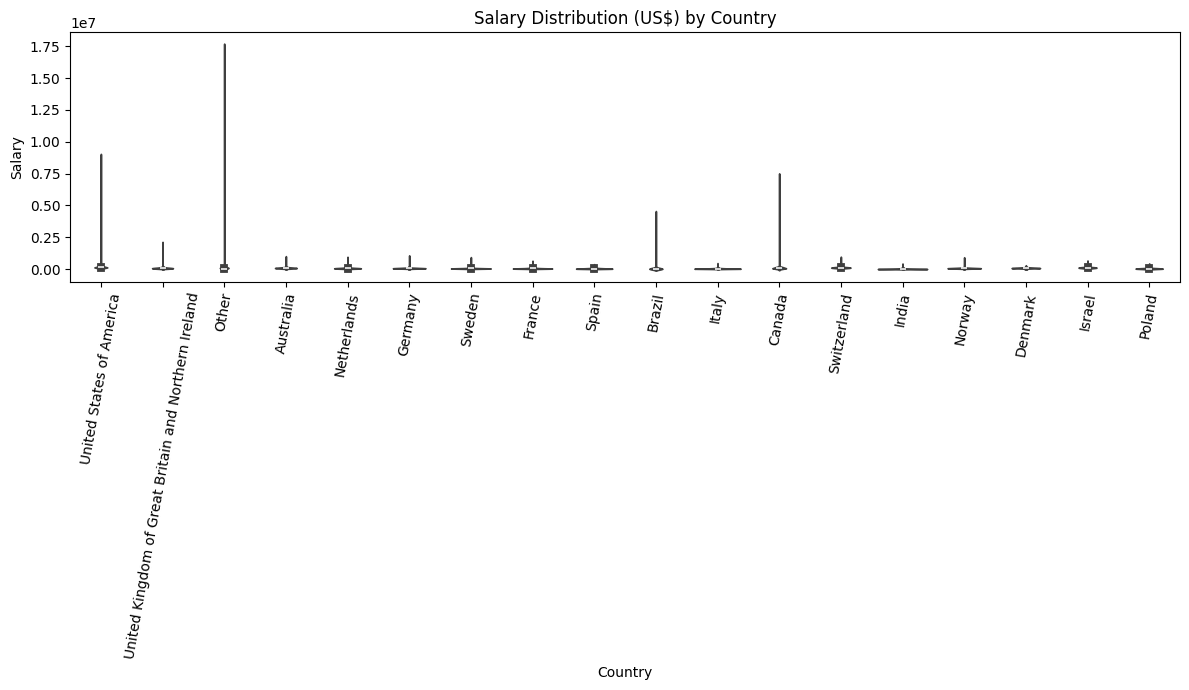

In [12]:

plt.figure(figsize=(12, 7))
sns.violinplot(x='Country', y='Salary', data=df)
plt.title('Salary Distribution (US$) by Country')
plt.ylabel('Salary')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

In [13]:
df = df[
    (df["Salary"] >= 12000) & 
    (df["Salary"] <= 250000) & 
    (df["Country"] != "Other")
]


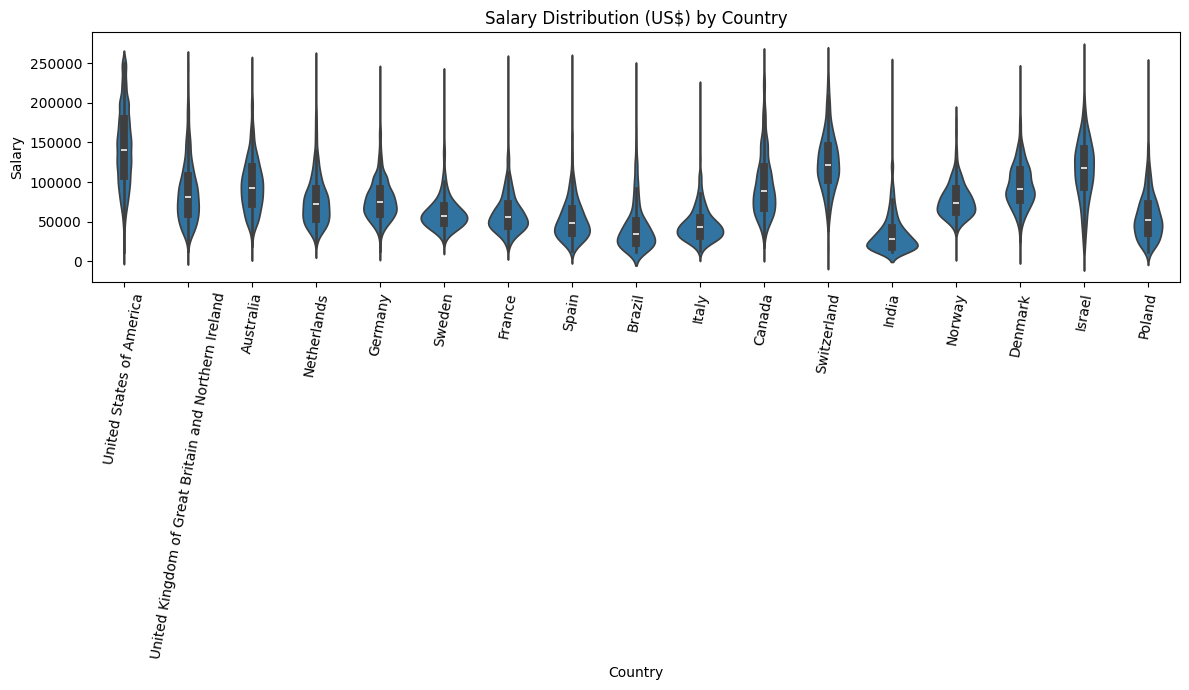

In [14]:

plt.figure(figsize=(12, 7))
sns.violinplot(x='Country', y='Salary', data=df)
plt.title('Salary Distribution (US$) by Country')
plt.ylabel('Salary')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()


In [15]:
df["YearsCodePro"].unique()

array(['23', '7', '21', '3', '9', 'Less than 1 year', '10', '2', '6',
       '14', '5', '15', '19', '13', '16', '28', '24', '25', '12', '4',
       '20', '8', '18', '30', '27', '17', '43', '38', '33', '29', '22',
       '1', '11', '34', '42', '26', '31', '36', '39', '40', '32', '44',
       '37', '35', '48', 'More than 50 years', '45', '41', '50', '46',
       '49', '47'], dtype=object)

In [16]:
def clean_experience(x):
    try:
        if pd.isna(x):
            return None
        x = str(x).strip()
        if x == 'More than 50 years':
            return 50
        elif x == 'Less than 1 year':
            return 0.5
        else:
            return float(x)
    except ValueError:
        return None  # fallback if conversion fails


In [17]:
df["YearsCodePro"] = df["YearsCodePro"].apply(clean_experience)

In [18]:
df["EdLevel"].unique()

array(['Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
       'Some college/university study without earning a degree',
       'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Professional degree (JD, MD, Ph.D, Ed.D, etc.)',
       'Associate degree (A.A., A.S., etc.)',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Primary/elementary school', 'Something else'], dtype=object)

In [19]:
def clean_education(x):
    if "Bachelor" in x:
        return "Bachelor's"
    elif "Master" in x:
        return "Master's"
    elif "Professional degree" in x or "Ph.D" in x:
        return "Postgraduate"
    elif "Secondary" in x or "Primary" in x:
        return "School"
    else:
        return "Other"
df["EdLevel"] = df["EdLevel"].apply(clean_education)

In [20]:
df["EdLevel"].unique()

array(["Bachelor's", 'Other', "Master's", 'Postgraduate', 'School'],
      dtype=object)

In [21]:
education = LabelEncoder()
df['EdLevel'] = education.fit_transform(df['EdLevel'])
df["EdLevel"].unique()

array([0, 2, 1, 3, 4])

In [22]:
country = LabelEncoder()
df['Country'] = country.fit_transform(df['Country'])
df["Country"].unique()


array([16, 15,  0,  9,  5, 13,  4, 12,  1,  8,  2, 14,  6, 10,  3,  7, 11])

In [23]:
dev=LabelEncoder()
df['DevType'] = df['DevType'].apply(lambda x: x.split(',')[0] if isinstance(x, str) else x)
df['DevType'] = dev.fit_transform(df['DevType'])
df["DevType"].unique()


array([ 8,  4,  3, 21, 19, 24, 12,  5, 16,  2,  7, 13, 22, 18,  0, 17,  9,
       14, 11, 20, 10, 15,  6,  1, 23])

In [24]:
orgsize = LabelEncoder()
df['OrgSize'] = orgsize.fit_transform(df['OrgSize'])
df["OrgSize"].unique()

array([6, 3, 0, 1, 4, 2, 7, 5, 9, 8])

In [25]:
remote = LabelEncoder()
df['RemoteWork'] = remote.fit_transform(df['RemoteWork'])
df["RemoteWork"].unique()


array([0, 2, 1])

In [26]:
with open("label_encoders.pkl", "wb") as f:
    pickle.dump({
        "education": education,
        "country": country,
        "dev": dev,
        "orgsize": orgsize,
        "remote": remote,
    }, f)


In [27]:
y = np.log1p(df['Salary'])  
X = df.drop("Salary", axis=1)


In [28]:
# Combine X and y to drop rows where y is NaN
data = pd.concat([X, y], axis=1)

# Drop rows where target is NaN
data = data.dropna(subset=[y.name])

# Separate back into X and y
X = data.drop(y.name, axis=1)
y = data[y.name]


In [29]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:


# Define parameter distribution
param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None]
}

# Base model
rf = RandomForestRegressor(random_state=42)

# Randomized Search CV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit model (use your actual X and y variables if not splitting)
random_search.fit(X_train, y_train)


# Best model
best_model = random_search.best_estimator_

# Predict and evaluate
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)



Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [31]:
print("Best Parameters:", random_search.best_params_)
print(f"RMSE: ${rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

Best Parameters: {'n_estimators': 150, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 10}
RMSE: $0.35
R² Score: 0.6526


In [32]:
importances = best_model.feature_importances_
features = X.columns
feature_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
feature_df.to_csv("feature_imp.csv", index=False)


In [33]:
with open("salary_model.pkl", "wb") as f:
    pickle.dump(best_model, f)


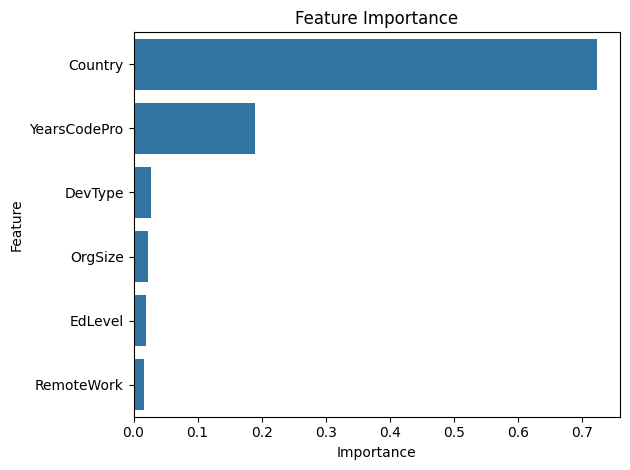

In [34]:

filtered_df = feature_df[feature_df['Importance'] > 0.01]

filtered_df = filtered_df.sort_values(by='Importance', ascending=False)


sns.barplot(data=filtered_df, x='Importance', y='Feature')
plt.title("Feature Importance")
plt.tight_layout()
plt.show()


In [39]:
df['CountryName'] = df['Country'].apply(lambda x: country.classes_[int(x)] if pd.notnull(x) else 'Unknown')

df['EducationLevel'] = df['EdLevel'].apply(lambda x: education.classes_[int(x)] if pd.notnull(x) else 'Unknown')
df['DevTypeLabel'] = df['DevType'].apply(lambda x: dev.classes_[int(x)] if pd.notnull(x) else 'Unknown')
df['OrgSizeLabel'] = df['OrgSize'].apply(lambda x: orgsize.classes_[int(x)] if pd.notnull(x) else 'Unknown')
orgsize_short = {
    "Just me - I am a freelancer, sole proprietor, etc.": "Freelancer",
    "I don’t know": "Unknown",
    "10 to 19 employees": "10-19",
    "20 to 99 employees": "20-99",
    "100 to 499 employees": "100-499",
    "500 to 999 employees": "500-999",
    "1,000 to 4,999 employees": "1k-4.9k",
    "5,000 to 9,999 employees": "5k-9.9k",
    "10,000 or more employees": "10k+"
}
df['OrgSizeLabel'] = df['OrgSizeLabel'].map(orgsize_short).fillna(df['OrgSizeLabel'])
df['RemoteWorkLabel'] = df['RemoteWork'].apply(lambda x: remote.classes_[int(x)] if pd.notnull(x) else 'Unknown')

remote_short = {
    "Hybrid (some remote, some in-person)": "Hybrid",
    "In-person": "In-person",
    "Remote": "Remote"
}

df['RemoteWorkLabel'] = df['RemoteWorkLabel'].map(remote_short).fillna(df['RemoteWorkLabel'])



In [ ]:
# Export all required files to the salaryPrediction directory for deployment
df.to_csv("salaryPrediction/cleaned_data.csv", index=False)
feature_df.to_csv("salaryPrediction/feature_imp.csv", index=False)
with open("salaryPrediction/salary_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
with open("salaryPrediction/label_encoders.pkl", "wb") as f:
    pickle.dump({
        "education": education,
        "country": country,
        "dev": dev,
        "orgsize": orgsize,
        "remote": remote,
    }, f)